In [1]:
import os
import sys
from pathlib import Path
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords
from nltk import pos_tag, pos_tag_sents
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score

sys.path.append('../')
from utils import utils

%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
# Get the names of the files to create labels and examples DataFrames
p = Path('../data/op_spam/')
files = list(p.rglob('*.txt'))

labels = [re.search('(trut|deceptiv)\w', str(file)).group() for file in files]
reviews = [file.read_text().lower() for file in files]
labels_df = pd.DataFrame(labels, columns=['label'])
reviews_df = pd.DataFrame(reviews, columns=['hotel_review'])
df = pd.merge(reviews_df, labels_df, left_index=True, right_index=True)
df.head()

,hotel_review,label
0,we stayed at the schicago hilton for 4 days an...,deceptive
1,hotel is located 1/2 mile from the train stati...,deceptive
2,i made my reservation at the hilton chicago be...,deceptive
3,"when most people think hilton, they think luxu...",deceptive
4,my husband and i recently stayed stayed at the...,deceptive


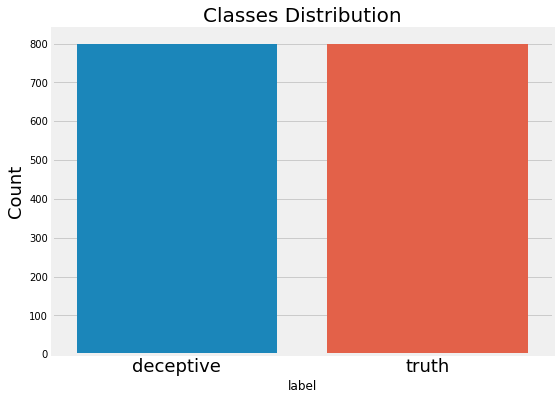

In [13]:
utils.plot_class_dist(df.label, ['deceptive', 'truth'])

In [3]:
# Add field that remove stopwords from reviews
stop = stopwords.words('english')
df['review_without_stopwords'] = df['hotel_review'].apply(
    lambda review: ' '.join(
        [word for word in review.split() if word not in stop]))

df.head()

,hotel_review,label,review_without_stopwords
0,we stayed at the schicago hilton for 4 days an...,deceptive,stayed schicago hilton 4 days 3 nights confere...
1,hotel is located 1/2 mile from the train stati...,deceptive,hotel located 1/2 mile train station quite hik...
2,i made my reservation at the hilton chicago be...,deceptive,made reservation hilton chicago believing goin...
3,"when most people think hilton, they think luxu...",deceptive,"people think hilton, think luxury. know did. w..."
4,my husband and i recently stayed stayed at the...,deceptive,husband recently stayed stayed hilton chicago ...


In [4]:
# Add part of speech tag field
def pos_tag(document):
    return TextBlob(document).tags

df['pos'] = df['review_without_stopwords'].apply(pos_tag)
df.head()

,hotel_review,label,review_without_stopwords,pos
0,we stayed at the schicago hilton for 4 days an...,deceptive,stayed schicago hilton 4 days 3 nights confere...,"[(stayed, VBN), (schicago, JJ), (hilton, NN), ..."
1,hotel is located 1/2 mile from the train stati...,deceptive,hotel located 1/2 mile train station quite hik...,"[(hotel, NN), (located, VBD), (1/2, CD), (mile..."
2,i made my reservation at the hilton chicago be...,deceptive,made reservation hilton chicago believing goin...,"[(made, VBN), (reservation, NN), (hilton, NN),..."
3,"when most people think hilton, they think luxu...",deceptive,"people think hilton, think luxury. know did. w...","[(people, NNS), (think, VBP), (hilton, NN), (t..."
4,my husband and i recently stayed stayed at the...,deceptive,husband recently stayed stayed hilton chicago ...,"[(husband, NN), (recently, RB), (stayed, VBD),..."


In [5]:
df['pos'] = df['pos'].apply(lambda review: ' '.join(['/'.join(word) for word in review]))
df.head()

,hotel_review,label,review_without_stopwords,pos
0,we stayed at the schicago hilton for 4 days an...,deceptive,stayed schicago hilton 4 days 3 nights confere...,stayed/VBN schicago/JJ hilton/NN 4/CD days/NNS...
1,hotel is located 1/2 mile from the train stati...,deceptive,hotel located 1/2 mile train station quite hik...,hotel/NN located/VBD 1/2/CD mile/NN train/NN s...
2,i made my reservation at the hilton chicago be...,deceptive,made reservation hilton chicago believing goin...,made/VBN reservation/NN hilton/NN chicago/NN b...
3,"when most people think hilton, they think luxu...",deceptive,"people think hilton, think luxury. know did. w...",people/NNS think/VBP hilton/NN think/VBP luxur...
4,my husband and i recently stayed stayed at the...,deceptive,husband recently stayed stayed hilton chicago ...,husband/NN recently/RB stayed/VBD stayed/JJ hi...


In [7]:
# Split the data
review_train, review_test, labels_train, labels_test = train_test_split(
    df['pos'], df['label'], test_size=0.2)

In [8]:
# Vectorize the reviews
tf_vect = TfidfVectorizer()
X_train = tf_vect.fit_transform(review_train)
X_test = tf_vect.transform(review_test)

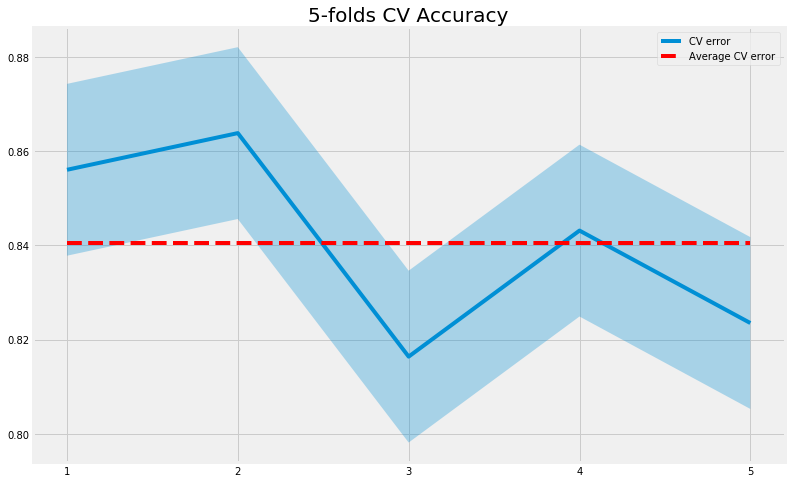

In [14]:
clf = RandomForestClassifier(n_estimators=100)
utils.plot_cv_error(cross_val_score(clf, X_train, labels_train, cv=5))

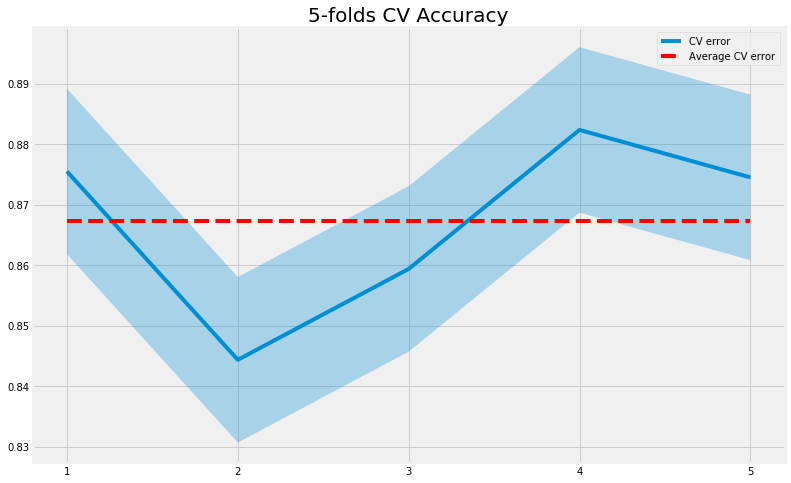

In [15]:
svm = SVC(C=10, gamma=0.001, kernel='linear')
utils.plot_cv_error(cross_val_score(svm, X_train, labels_train, cv=5))